In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms


from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from glob import glob

dataset

In [2]:
preprocess = transforms.Compose([
    transforms.Resize((64,128)),
    transforms.ToTensor()
])

In [3]:
class ImageDataset(Dataset):
    
    def __init__(self, root):
        self.root = root
        self.img_path = os.path.join(self.root,'train')
        self.img_paths = os.listdir(self.img_path)[:10000]
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_path,self.img_paths[idx])
        img = Image.open(img_path)
        img = preprocess(img)
        img1 = img[:,:,:64]
        img2 = img[:,:,64:]

        return img1,img2

In [4]:
dataset = ImageDataset('edges2shoes/')

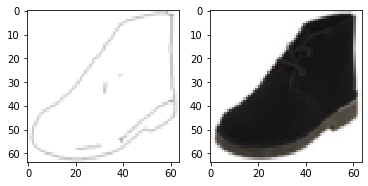

In [5]:
plt.subplot(1,2,1)
plt.imshow(dataset[0][0].permute(1,2,0).numpy())
plt.subplot(1,2,2)
plt.imshow(dataset[0][1].permute(1,2,0).numpy())

In [6]:
dataloader = DataLoader(dataset,batch_size=4)

model

In [7]:
class ConvINLRelu(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(ConvINLRelu,self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(inplace=True)
        )
        
    def forward(self,x):
        tmp = self.conv(x)
        
        return tmp

In [8]:
class Discriminator_Network(nn.Module):
    
    def __init__(self):
        super(Discriminator_Network,self).__init__()
        self.discriminator = nn.Sequential(
            ConvINLRelu(6,32),
            ConvINLRelu(32,64),
            ConvINLRelu(64,128),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(128,1,3,padding=1)
        )
        
    def forward(self,x,y):
        tmp = torch.cat([x,y],dim=1)
        tmp = self.discriminator(tmp)
        return tmp

In [9]:
class DownSampling(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(DownSampling,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    
    def forward(self, x):
        return self.model(x)

In [10]:
class UpSampling(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(UpSampling,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_ch,int(out_ch/2),2,stride=2)
        )
    
    def forward(self, x, feature_map):
        x = self.model(x)
        return torch.cat([x,feature_map],dim=1)

In [11]:
class Generator_Network(nn.Module):
    
    def __init__(self, n_classes):
        super(Generator_Network,self).__init__()
        self.down1 = DownSampling(3,64) #64,112
        self.down2 = DownSampling(64,128) #128,56
        self.down3 = DownSampling(128,256) #256,28
        self.down4 = DownSampling(256,512) #512,14
        self.expand = DownSampling(512,1024) #1024,7
        self.up1 = UpSampling(1024,1024) #512+512,14
        self.up2 = UpSampling(1024,512) #256+256,28
        self.up3 = UpSampling(512,256) #128+128,56
        self.up4 = UpSampling(256,128) #64+64,112
        self.up5 = nn.ConvTranspose2d(128,64,2,stride=2) #64, 224
        self.conv = nn.Conv2d(64,n_classes,1) #20, 224
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        intermediate = self.expand(d4)
        u1 = self.up1(intermediate,d4)
        u2 = self.up2(u1,d3)
        u3 = self.up3(u2,d2)
        u4 = self.up4(u3,d1)
        u5 = self.up5(u4)
        out = self.conv(u5)
        return out

training

In [12]:
gen = Generator_Network(3).cuda()
dis = Discriminator_Network().cuda()

In [13]:
criterion_gan = nn.MSELoss()
criterion_pixel = nn.L1Loss()
optim_G = torch.optim.Adam(gen.parameters(),lr=0.0002,betas=(0.5,0.999))
optim_D = torch.optim.Adam(dis.parameters(),lr=0.0002,betas=(0.5,0.999))

In [14]:
epoches = 5

In [15]:
gen.train()
dis.train()
for e in range(epoches):
    running_loss_G = 0.0
    running_loss_D = 0.0
    for data in tqdm(dataloader):
        real_img, real_label = data
        real_img = real_img.cuda()
        real_label = real_label.cuda()

        valid = torch.ones(real_img.size(0), 1, 65, 65).cuda()
        fake = torch.zeros(real_img.size(0), 1, 65, 65).cuda()
                
        optim_G.zero_grad()
        gen_img = gen(real_img)
        g_loss = criterion_gan(dis(gen_img, real_img), valid)
        g2_loss = criterion_pixel(gen_img, real_label)
        loss_G = g_loss + 100 * g2_loss
        loss_G.backward()
        optim_G.step()
        running_loss_G+=loss_G.item()

        optim_D.zero_grad()
        real_loss = criterion_gan(dis(real_label,real_img), valid)
        fake_loss = criterion_gan(dis(gen_img.detach(),real_img), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optim_D.step()
        running_loss_D+=d_loss.item()
        
    print(f'epoch {e+1}: D:{running_loss_D/len(dataset)} G:{running_loss_G/len(dataset)}')

  0%|                                                                                 | 1/2500 [00:00<04:29,  9.26it/s]

epoch 1: D:0.01916449018670246 G:3.0097504346847535


  0%|                                                                                 | 1/2500 [00:00<04:23,  9.49it/s]

epoch 2: D:0.0021923059096676297 G:2.570540050268173


  0%|                                                                                 | 2/2500 [00:00<04:20,  9.58it/s]

epoch 3: D:0.0010305745503224899 G:2.399280370569229


  0%|                                                                                 | 1/2500 [00:00<04:24,  9.43it/s]

epoch 4: D:0.00067958960570395 G:2.276600445151329


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:22<00:00,  9.53it/s]

epoch 5: D:0.0007296876958454959 G:2.1716228539943696


evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


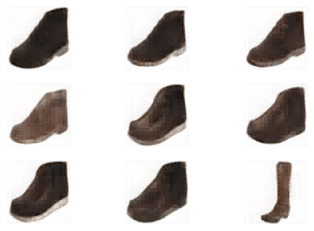

In [16]:
# 合成圖片

for i in range(3):
    for j in range(3):
        with torch.no_grad():
            gen.eval()
            
            test_img = dataset[3*i+j][0].unsqueeze(0).cuda()
            gen_img = gen(test_img).detach().cpu().numpy()
            gen_img = np.rollaxis(gen_img[0],0,3)
            
            plt.subplot(3,3,1+i*3+j)
            plt.axis('off')
            plt.imshow(gen_img)

save

In [38]:
torch.save(gen.state_dict(),'gen.pth')